# Retention dataset

In [1]:
import pandas as pd
import numpy as np
import pyarrow
from datetime import datetime, date, timedelta
import time

from google.cloud import storage
from google.cloud import bigquery

import sys
import os

sys.path.append(os.path.realpath('../../'))
import data_generator

In [2]:
bigquery_client = bigquery.Client.from_service_account_json('../../credentials/data-analysis-sql-309220-6ce084250abd.json')

In [3]:
date_start = date(2021,1,1)
date_end = date(2021,3,31)
dates_list = [(date_start + timedelta(x)).strftime('%Y-%m-%d') for x in range((date_end - date_start).days + 1)]


n = 0 # set counter
df = pd.DataFrame()



for date in dates_list:
    seed = int(time.mktime(datetime.strptime(date, '%Y-%m-%d').timetuple()))
    rand = np.random.default_rng(seed)
    
    # define parameters
    params = {
        'dates': {
            'date': {
                'start': date,
                'end': date
            }
        },
        'categorical': {
            'user_id': {
                'categories': np.arange(1 if n==0 else n * 1000 + 1, 1001 if n==0 else n * 1000 + 1001)
            }
        }
    }
    
    rows = rand.integers(low=500, high=1500, size=None, dtype=int)
    df_temp = data_generator.create_dataset(rows=rows, params=params, seed=seed)
    df = df.append(df_temp)


    if n > 0:
        # add retention
        # define parameters
        params = {
            'dates': {
                'date': {
                    'start': date,
                    'end': date
                }
            },
            'categorical': {
                'user_id': {
                    'categories': df.user_id.unique()
                }
            }
        }  
        
        # retention
        rows = rand.integers(low=len(df.user_id.unique())/15 - 20*n, high=len(df.user_id.unique())/10 - 20*n, size=None, dtype=int)
        df_temp = data_generator.create_dataset(rows=rows, params=params, seed=seed)
        df = df.append(df_temp)        
        
    
    n += 1

In [4]:
print(df.sample(frac=0.00005).to_markdown(index=False))

| date       |   user_id |
|:-----------|----------:|
| 2021-03-30 |     50569 |
| 2021-02-20 |     50059 |
| 2021-02-11 |     12762 |
| 2021-03-23 |     10036 |
| 2021-02-01 |     31953 |
| 2021-03-29 |     87683 |
| 2021-02-04 |     34704 |
| 2021-01-30 |     29412 |
| 2021-03-06 |     64789 |
| 2021-03-26 |     43247 |
| 2021-03-16 |     74615 |


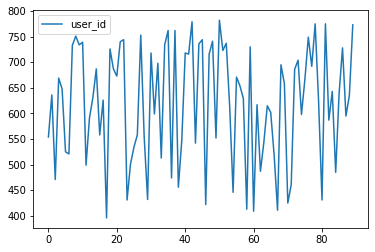

In [5]:
# New users
df.groupby('user_id')['date'].min().reset_index().groupby('date')['user_id'].count().reset_index().plot();

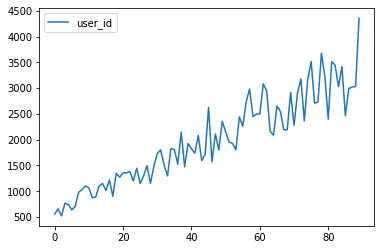

In [6]:
# Total users
df.groupby('date')['user_id'].nunique().reset_index().plot();

### Write the dataset to BigQuery

In [30]:
df.to_csv('app_open_temp.csv', index=False)

In [31]:
table_ref = bigquery_client.dataset('synthetic').table('app_open')

job_config = bigquery.LoadJobConfig()
job_config.source_format = bigquery.SourceFormat.CSV
job_config.skip_leading_rows = 1 # ignore the header
job_config.autodetect = True

with open('app_open_temp.csv', 'rb') as source_file:
    job = bigquery_client.load_table_from_file(
        source_file, table_ref, job_config=job_config
    )

job.result()

In [32]:
%%bash
rm app_open_temp.csv